# 2024-04-18 Carlos Meeting

Want to discuss:
- how to add in 4th pair
- number of rigs breaking

How to visualize this:

- show success of C222 with weaning off light guide 
    - over days:
        - pro anti perf 
        - non give pair perf 
        - give delay
        - give delivery
    - within session:
        - last 5 sessions
    
- number of animals per rig in last month 
    - fetch sessions table as df in last month for given animals
    - groupby animal id and plot number of rigs in the last month
    - plot number of rigs by hit rate, violation rate


In [2]:
import sys
sys.path.append('../training_performance')

import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 

# settingsb
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

[2024-04-17 17:39:52,460][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2024-04-17 17:39:54,367][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [39]:
animals = ["R033", "C222", "R024"]
date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=50)
df = create_trials_df_from_dj(animals, date_min, date_max)

Not all variables are the same length. Cannot create proper DataFrame
result: 3
hits: 3
violations: 3
temperror: 3
hit_rate: 2
error_rate: 2
violation_rate: 2
temp_error_rate: 2
n_lpokes: 2
n_cpokes: 2
n_rpokes: 2
trial_dur: 2
trial_start: 2
valid_early_spoke: 2
first_spoke: 2
first_lpoke: 2
first_rpoke: 2
n_settling_ins: 2
avg_settling_in: 2
cpoke_dur: 2
n_incorr_spokes_during_give_del: 2
stage: 2
curriculum: 2
sides: 3
SMA_set: 2
is_match: 3
sa: 2
sb: 2
stimuli_on: 2
settling_in_dur: 2
legal_cbreak_dur: 2
pre_dur: 2
adj_pre_dur: 2
stimulus_dur: 2
delay_dur: 2
post_dur: 2
sb_extra_dur: 2
viol_off_dur: 2
pre_go_dur: 2
inter_trial_dur: 2
go_type: 2
go_dur: 2
give_type_set: 2
give_type_imp: 2
give_frac: 2
give_delay_dur: 2
give_xtra_light_delay_dur: 2
give_use: 3
give_del_growth_type: 2
give_del_adagrow_trial_subset: 2
give_del_adagrow_alpha_plus: 2
give_del_adagrow_alpha_minus: 2
give_del_adagrow_threshold: 2
give_del_adagrow_subset_prev_perf: 2
give_del_adagrow_step_size: 2
give_del_ad

In [64]:
def plot_adaptive_threshold_summary_days(df, animal_id, stim_without_give=True):
    fig, ax = plt.subplots(4, 1, figsize=(12, 4 * 4), sharex=True)

    plot_df = df.query("animal_id == @animal_id").copy()

    plot_performance_by_pro_anti_over_days(
        plot_df, ax=ax[0], without_give=False, aesthetics=False
    )

    plot_performance_by_stim_over_days(
        plot_df, without_give=stim_without_give, ax=ax[1], aesthetics=False
    )

    plot_give_use_rate_days(
        plot_df, ax[2], aesthetics=False, title="Give Delivered Rate"
    )
    plot_give_delay_dur_days_line(
        plot_df, aesthetics=False, ax=ax[3], title="Avg. Delay Pre-Give"
    )

    # add info for adaptive threshold
    ax[2].set_title(
        f"Current $\\alpha_-= {plot_df.give_del_adagrow_alpha_minus.iloc[-1]}$"
    )

    _ = plt.xticks(rotation=45)
    ax[3].set(ylim=(0, None))

    plt.suptitle(f"{animal_id} Adaptive Growth Summary")

    return None

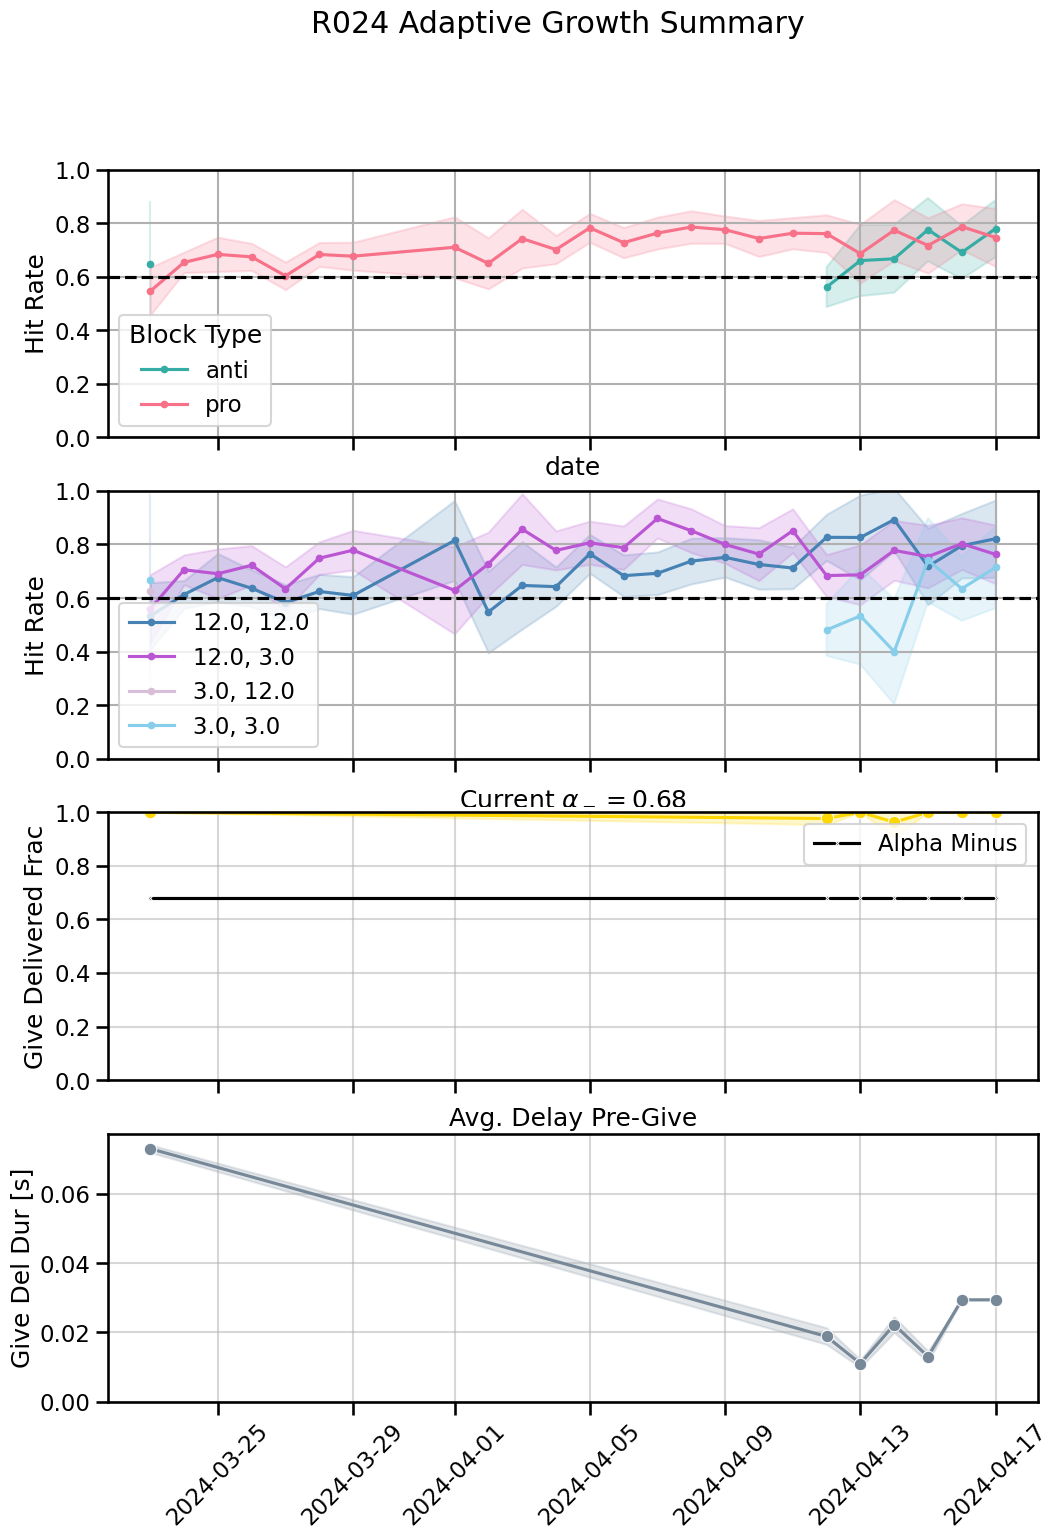

In [65]:
date_min = pd.Timestamp(2024, 3, 22).date()
plot_adaptive_threshold_summary_days(
    df.query("date > @date_min"), "R024", stim_without_give=False
)

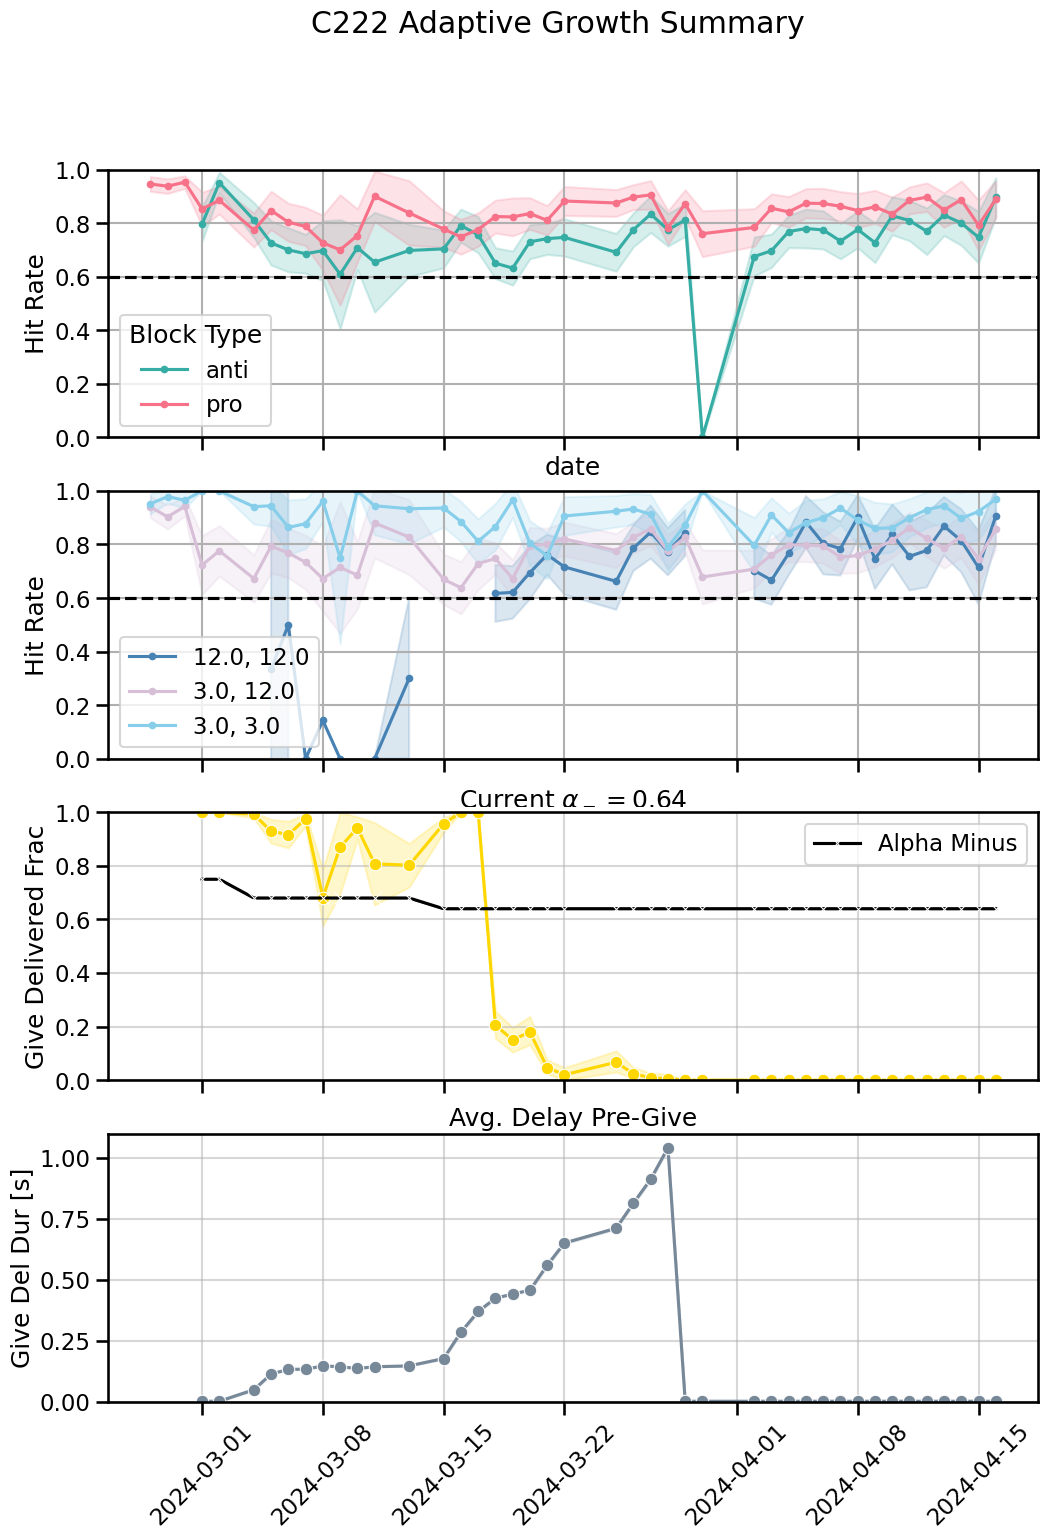

In [66]:
plot_adaptive_threshold_summary_days(df, "C222")

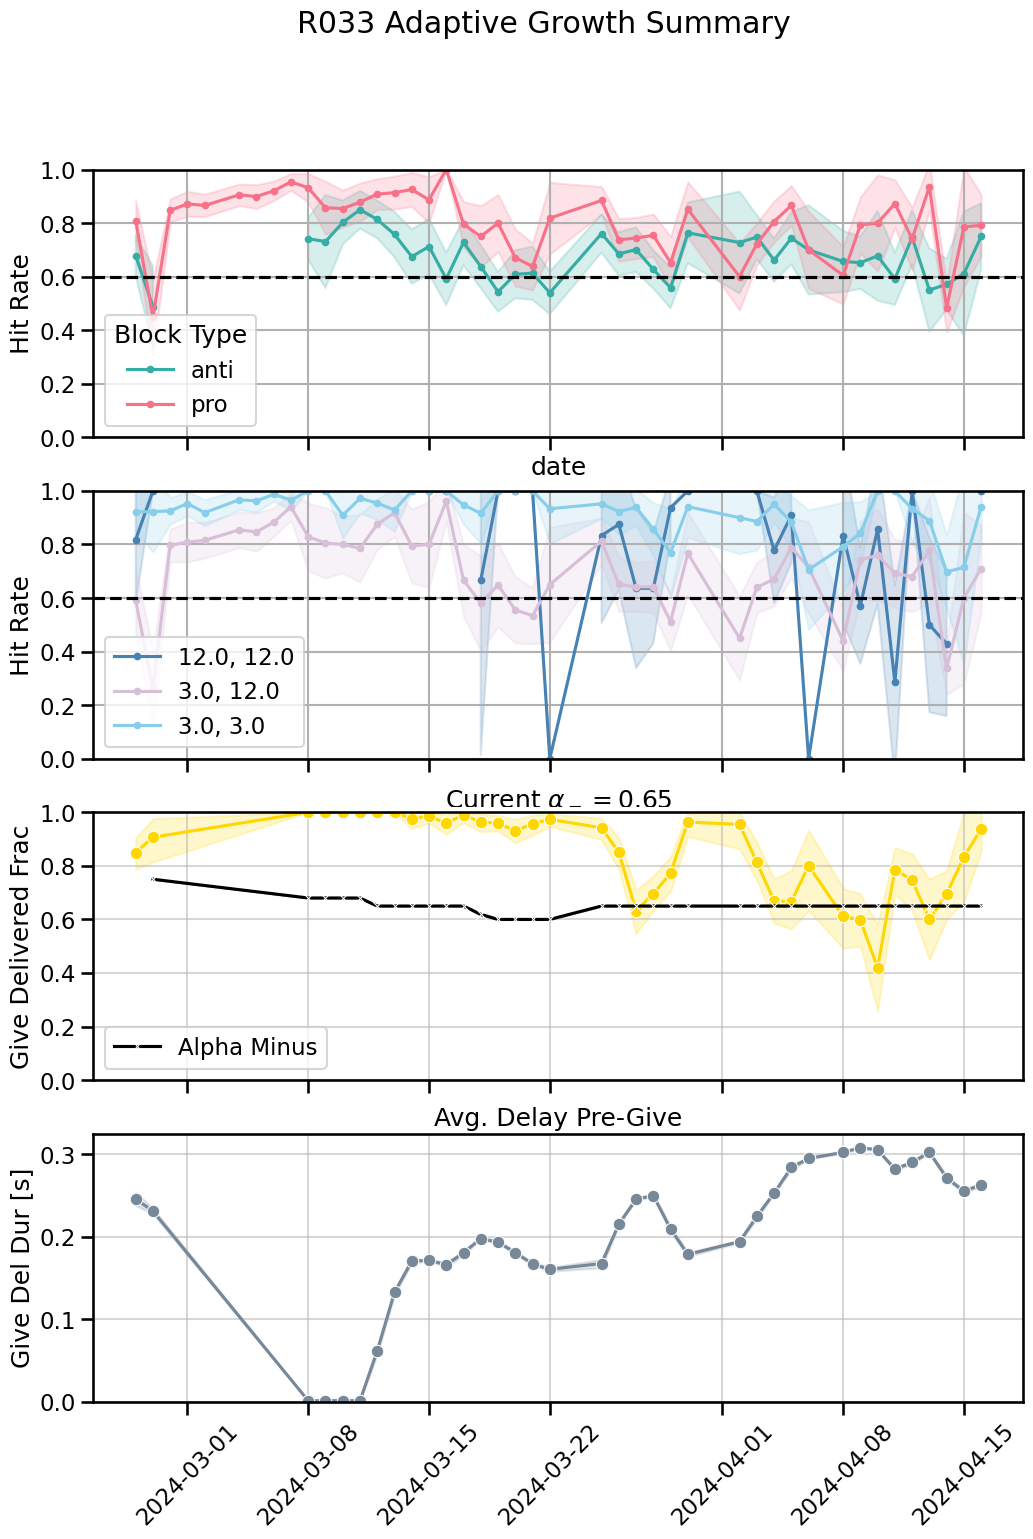

In [69]:
# date_min = pd.Timestamp(2024, 3, 22).date()
plot_adaptive_threshold_summary_days(df, "R033")

In [84]:
date_min = datetime.today().date() - timedelta(5)
c222 = df.query("animal_id=='C222' and date > @date_min")

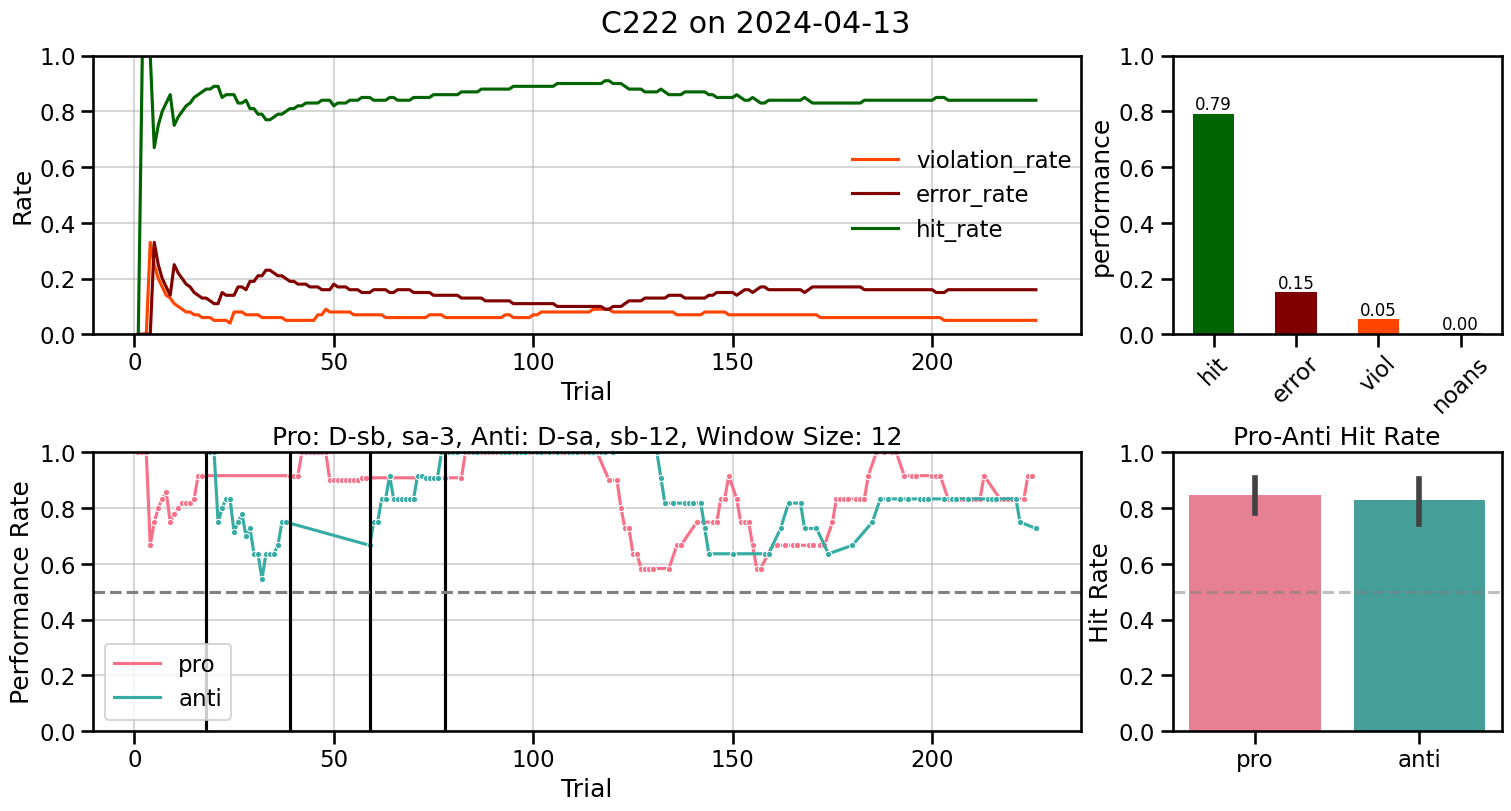

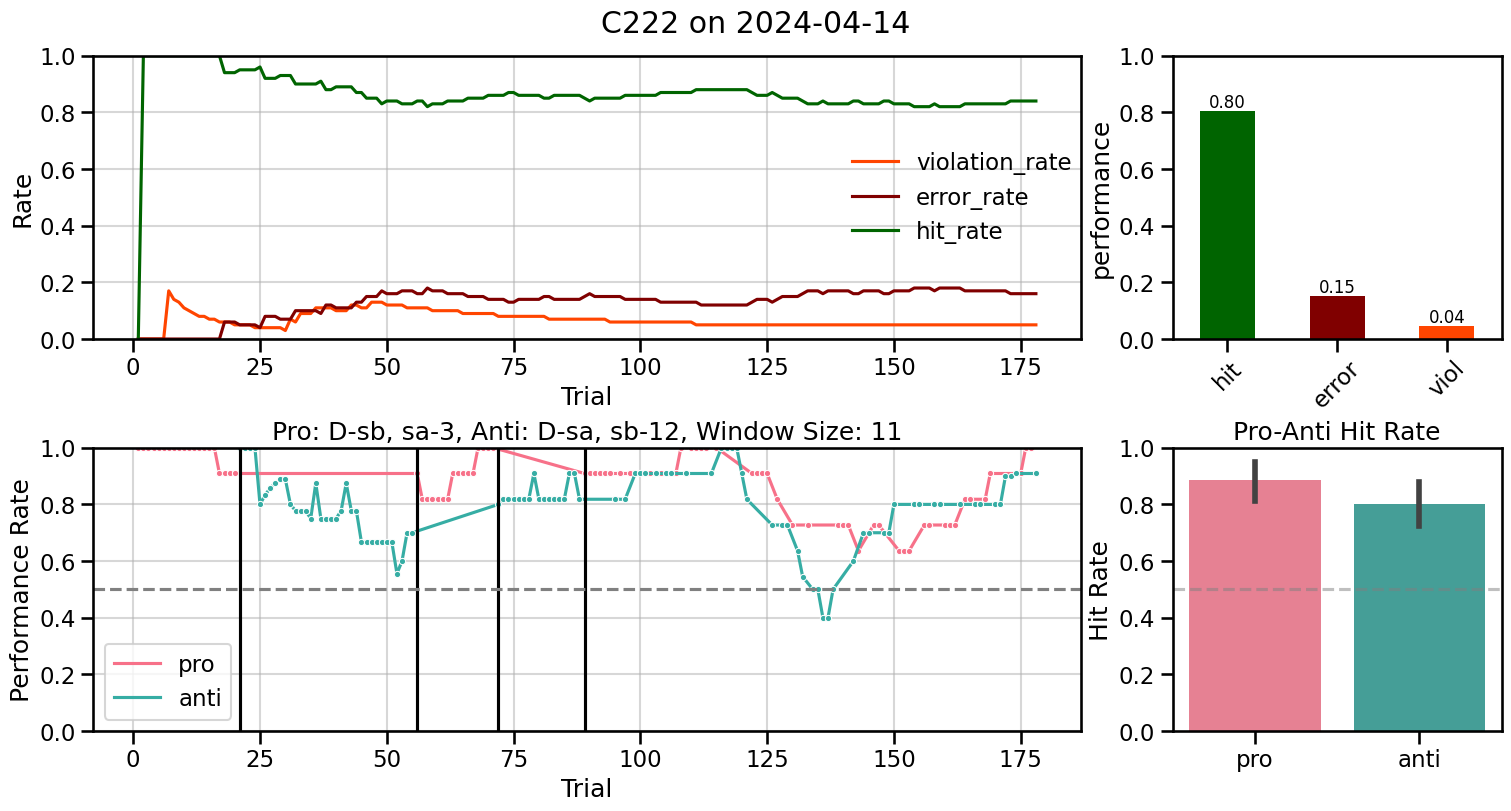

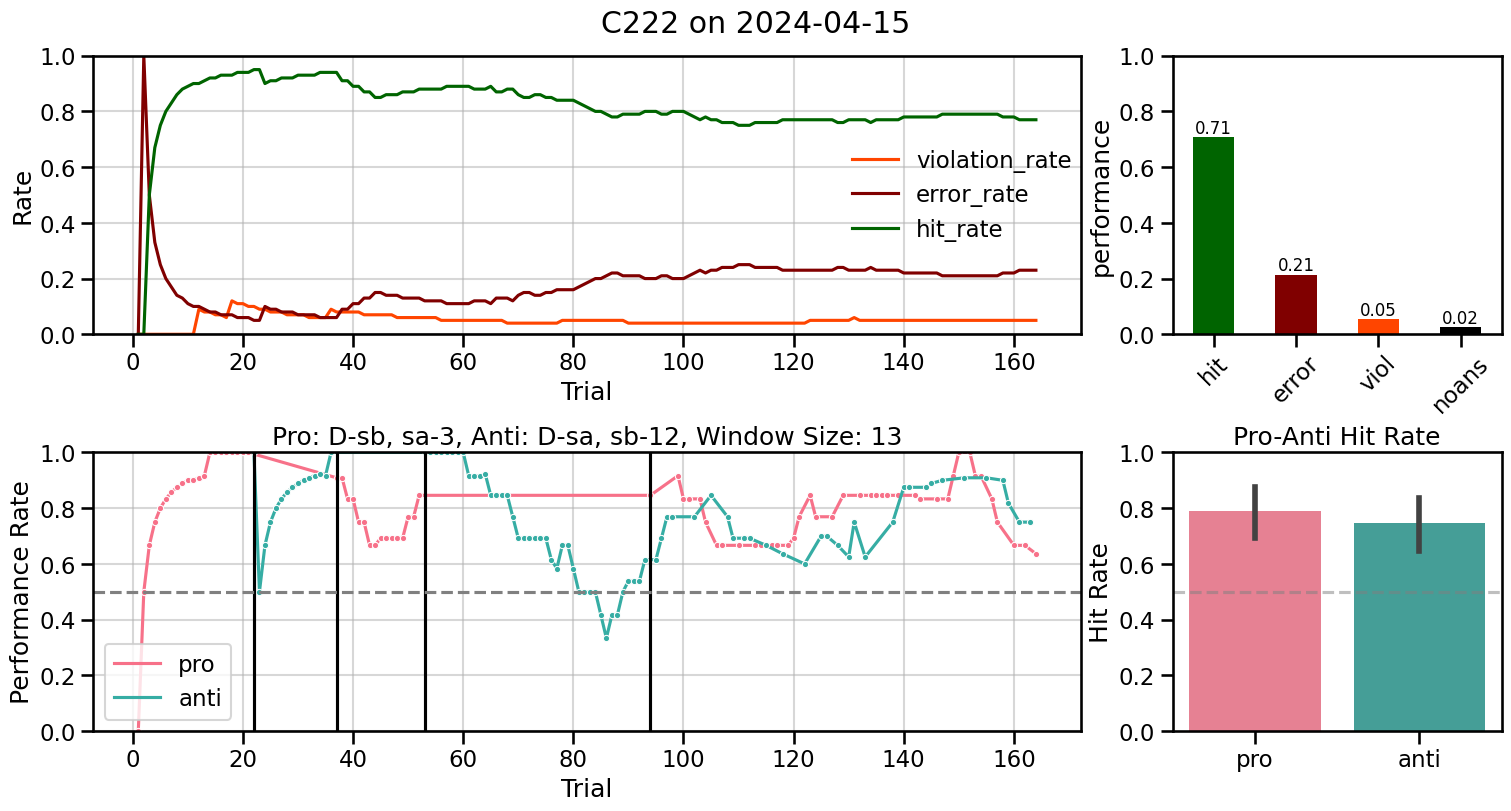

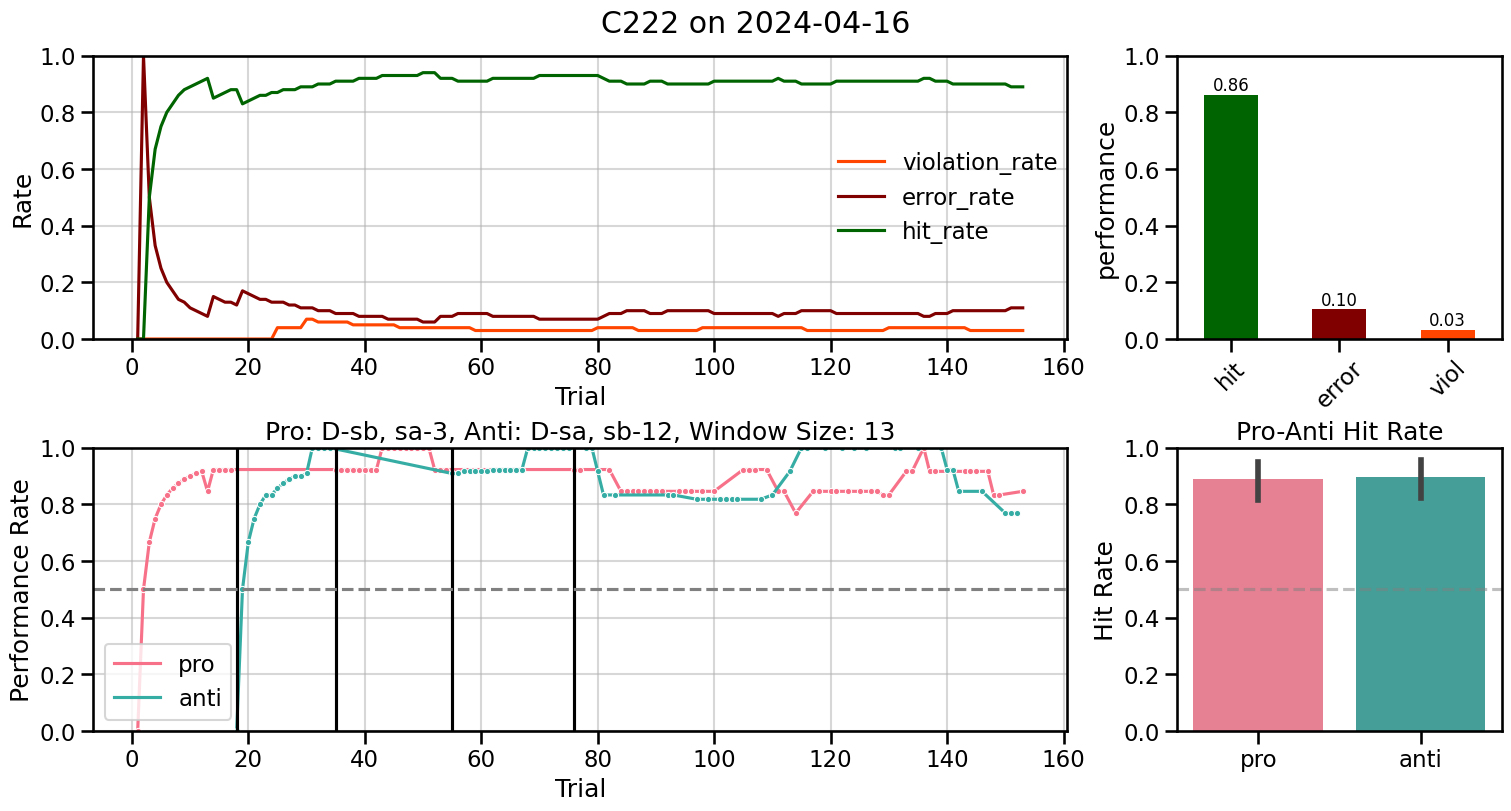

In [91]:
for idx, (date, sub_df) in enumerate(c222.groupby("date")):
    if len(sub_df.pro_anti_block_type.unique()) == 1:
        continue

    fig = plt.figure(constrained_layout=True, figsize=(15, 8))
    layout = """
        AAAB
        CCCD
    """
    ax_dict = fig.subplot_mosaic(layout)

    plot_performance_rates(sub_df, ax_dict["A"])
    plot_result_summary(sub_df, ax_dict["B"])

    plot_rolling_hit_rate_by_pro_anti(sub_df, ax_dict["C"])
    plot_hit_rate_by_pro_anti(sub_df, ax_dict["D"])

    fig.suptitle(f"C222 on {date}")

### Rigs 

In [104]:
bdata = dj.create_virtual_module("bdata", "bdata")
ratinfo = dj.create_virtual_module("intfo", "ratinfo")

In [117]:
print(ratinfo.Rats.describe())

# Brody Lab Rats
internalID           : int unsigned auto_increment  
---
free=0               : tinyint                      # whether or not the rat is available for use by any other experimenter
alert=0              : tinyint                      # whether or not there is an alert for special attention for the rat (e.g. sick, recent surgery, etc.)
experimenter=null    : varchar(20)                  # name of the experimenter
contact=null         : varchar(40)                  
ratname=null         : varchar(4)                   # name of the rat
training=0           : tinyint                      
comments=null        : varchar(500)                 
vendor="Taconic"     : varchar(40)                  # e.g. Taconic, Charles River, etc.
waterperday=30       : int                          # 0 for free water, otherwise the number of minutes the rat has access to water each day (may vary over time)
recovering=0         : tinyint                      # whether or not the rat is currently

In [124]:
# keys = [{"experimenter": "JessB"}, {"israt = 1"}]


rats = (ratinfo.Rats & {"israt = 1"} & {"experimenter": "JessB"}).fetch("ratname")

In [164]:
animal_keys = [{"ratname": animal} for animal in rats]

date_min, date_max = dju.return_date_window(n_days_back=21)
date_min_key = f"sessiondate >= '{date_min}'"
date_max_key = f"sessiondate <= '{date_max}'"

In [165]:
session_df = pd.DataFrame(
    (bdata.Sessions & animal_keys & date_min_key & date_max_key).fetch(as_dict=True)
)

[Text(0, 0.5, '# Rigs in last 21 days')]

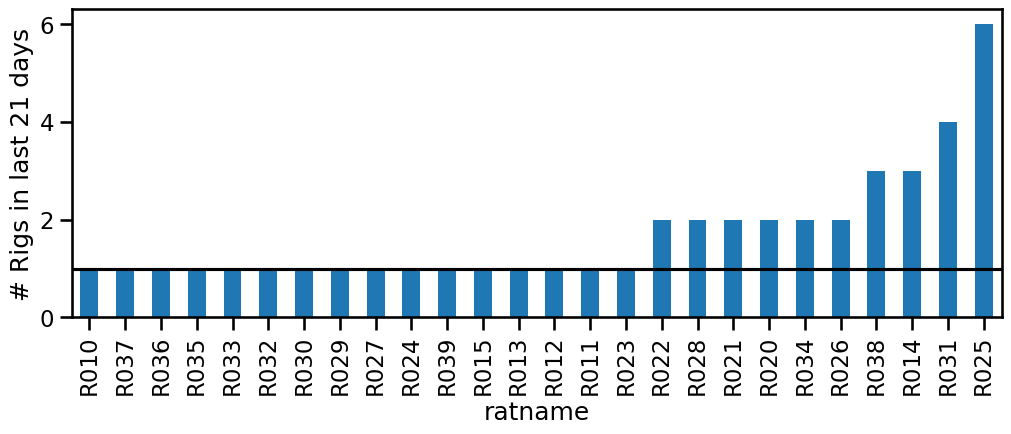

In [187]:
fig, ax = pu.make_fig()
session_df.groupby("ratname").hostname.nunique().sort_values().plot(kind="bar", ax=ax)
ax.axhline(1, color="k")
ax.set(ylabel="# Rigs in last 21 days")

In [167]:
session_df.columns

Index(['sessid', 'ratname', 'hostname', 'experimenter', 'starttime', 'endtime',
       'sessiondate', 'n_done_trials', 'comments', 'settings_file',
       'settings_path', 'data_file', 'data_path', 'video_file', 'video_path',
       'protocol', 'total_correct', 'right_correct', 'left_correct',
       'percent_violations', 'brokenbits', 'protocol_data', 'left_pokes',
       'center_pokes', 'right_pokes', 'technotes', 'IP_addr', 'crashed',
       'foodpuck'],
      dtype='object')

In [168]:
session_df["side_bias"] = session_df["right_correct"] - session_df["left_correct"]

In [177]:
rig_data = session_df.groupby("ratname").hostname.nunique().reset_index()

rig_data["avg_hit"] = rig_data.ratname.map(
    session_df.groupby("ratname").total_correct.mean()
)
rig_data["std_hit"] = rig_data.ratname.map(
    session_df.groupby("ratname").total_correct.std()
)

rig_data["avg_viol"] = rig_data.ratname.map(
    session_df.groupby("ratname").percent_violations.mean()
)
rig_data["std_viol"] = rig_data.ratname.map(
    session_df.groupby("ratname").percent_violations.std()
)

rig_data["avg_trials"] = rig_data.ratname.map(
    session_df.groupby("ratname").n_done_trials.mean()
)
rig_data["std_trials"] = rig_data.ratname.map(
    session_df.groupby("ratname").n_done_trials.std()
)
rig_data["avg_bias"] = rig_data.ratname.map(
    session_df.groupby("ratname").side_bias.mean().abs()
)

In [182]:
rig_data

,ratname,hostname,avg_hit,std_hit,avg_viol,std_viol,avg_trials,std_trials,avg_bias
0,R010,1,0.718947,0.058774,0.101579,0.065766,102.842105,44.739075,0.042105
1,R011,1,0.718000,0.049054,0.056500,0.099381,151.950000,63.299185,0.261500
2,R012,1,0.689000,0.051901,0.053500,0.102252,176.300000,56.879466,0.039500
3,R013,1,0.851429,0.198249,0.140476,0.111735,165.333333,54.456711,0.003333
4,R014,3,0.628000,0.164880,0.095000,0.142182,96.650000,37.063637,0.000500
5,R015,1,0.762000,0.191190,0.069000,0.073906,165.200000,67.349520,0.170000
6,R020,2,0.678571,0.133802,0.185714,0.243610,140.476190,42.587110,0.094286
7,R021,2,0.662381,0.346423,0.288095,0.357640,64.571429,38.351755,0.162381
8,R022,2,0.760909,0.183664,0.298182,0.214201,145.272727,42.055725,0.010455
9,R023,1,0.746190,0.052676,0.115238,0.096727,103.000000,26.748832,0.010952


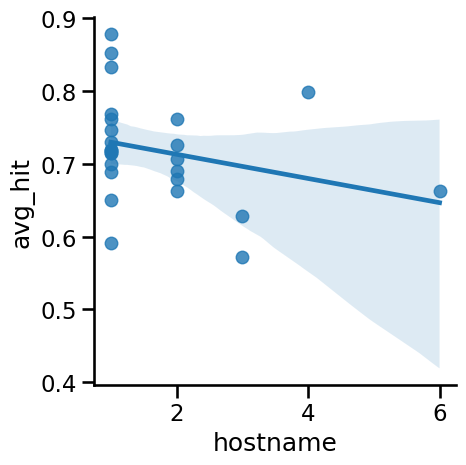

In [179]:
sns.lmplot(rig_data, x="hostname", y="avg_hit")

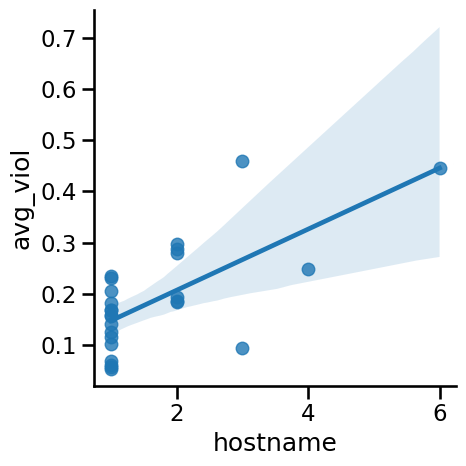

In [180]:
sns.lmplot(rig_data, x="hostname", y="avg_viol")

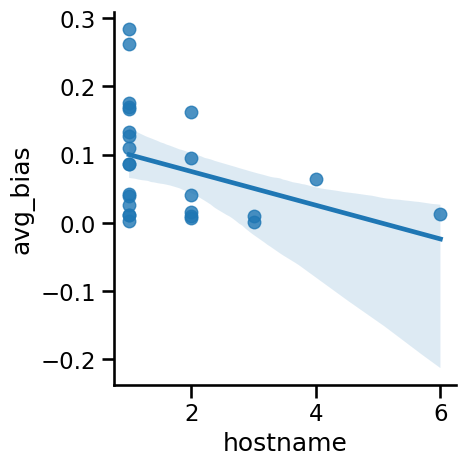

In [185]:
sns.lmplot(rig_data, x="hostname", y="avg_bias")

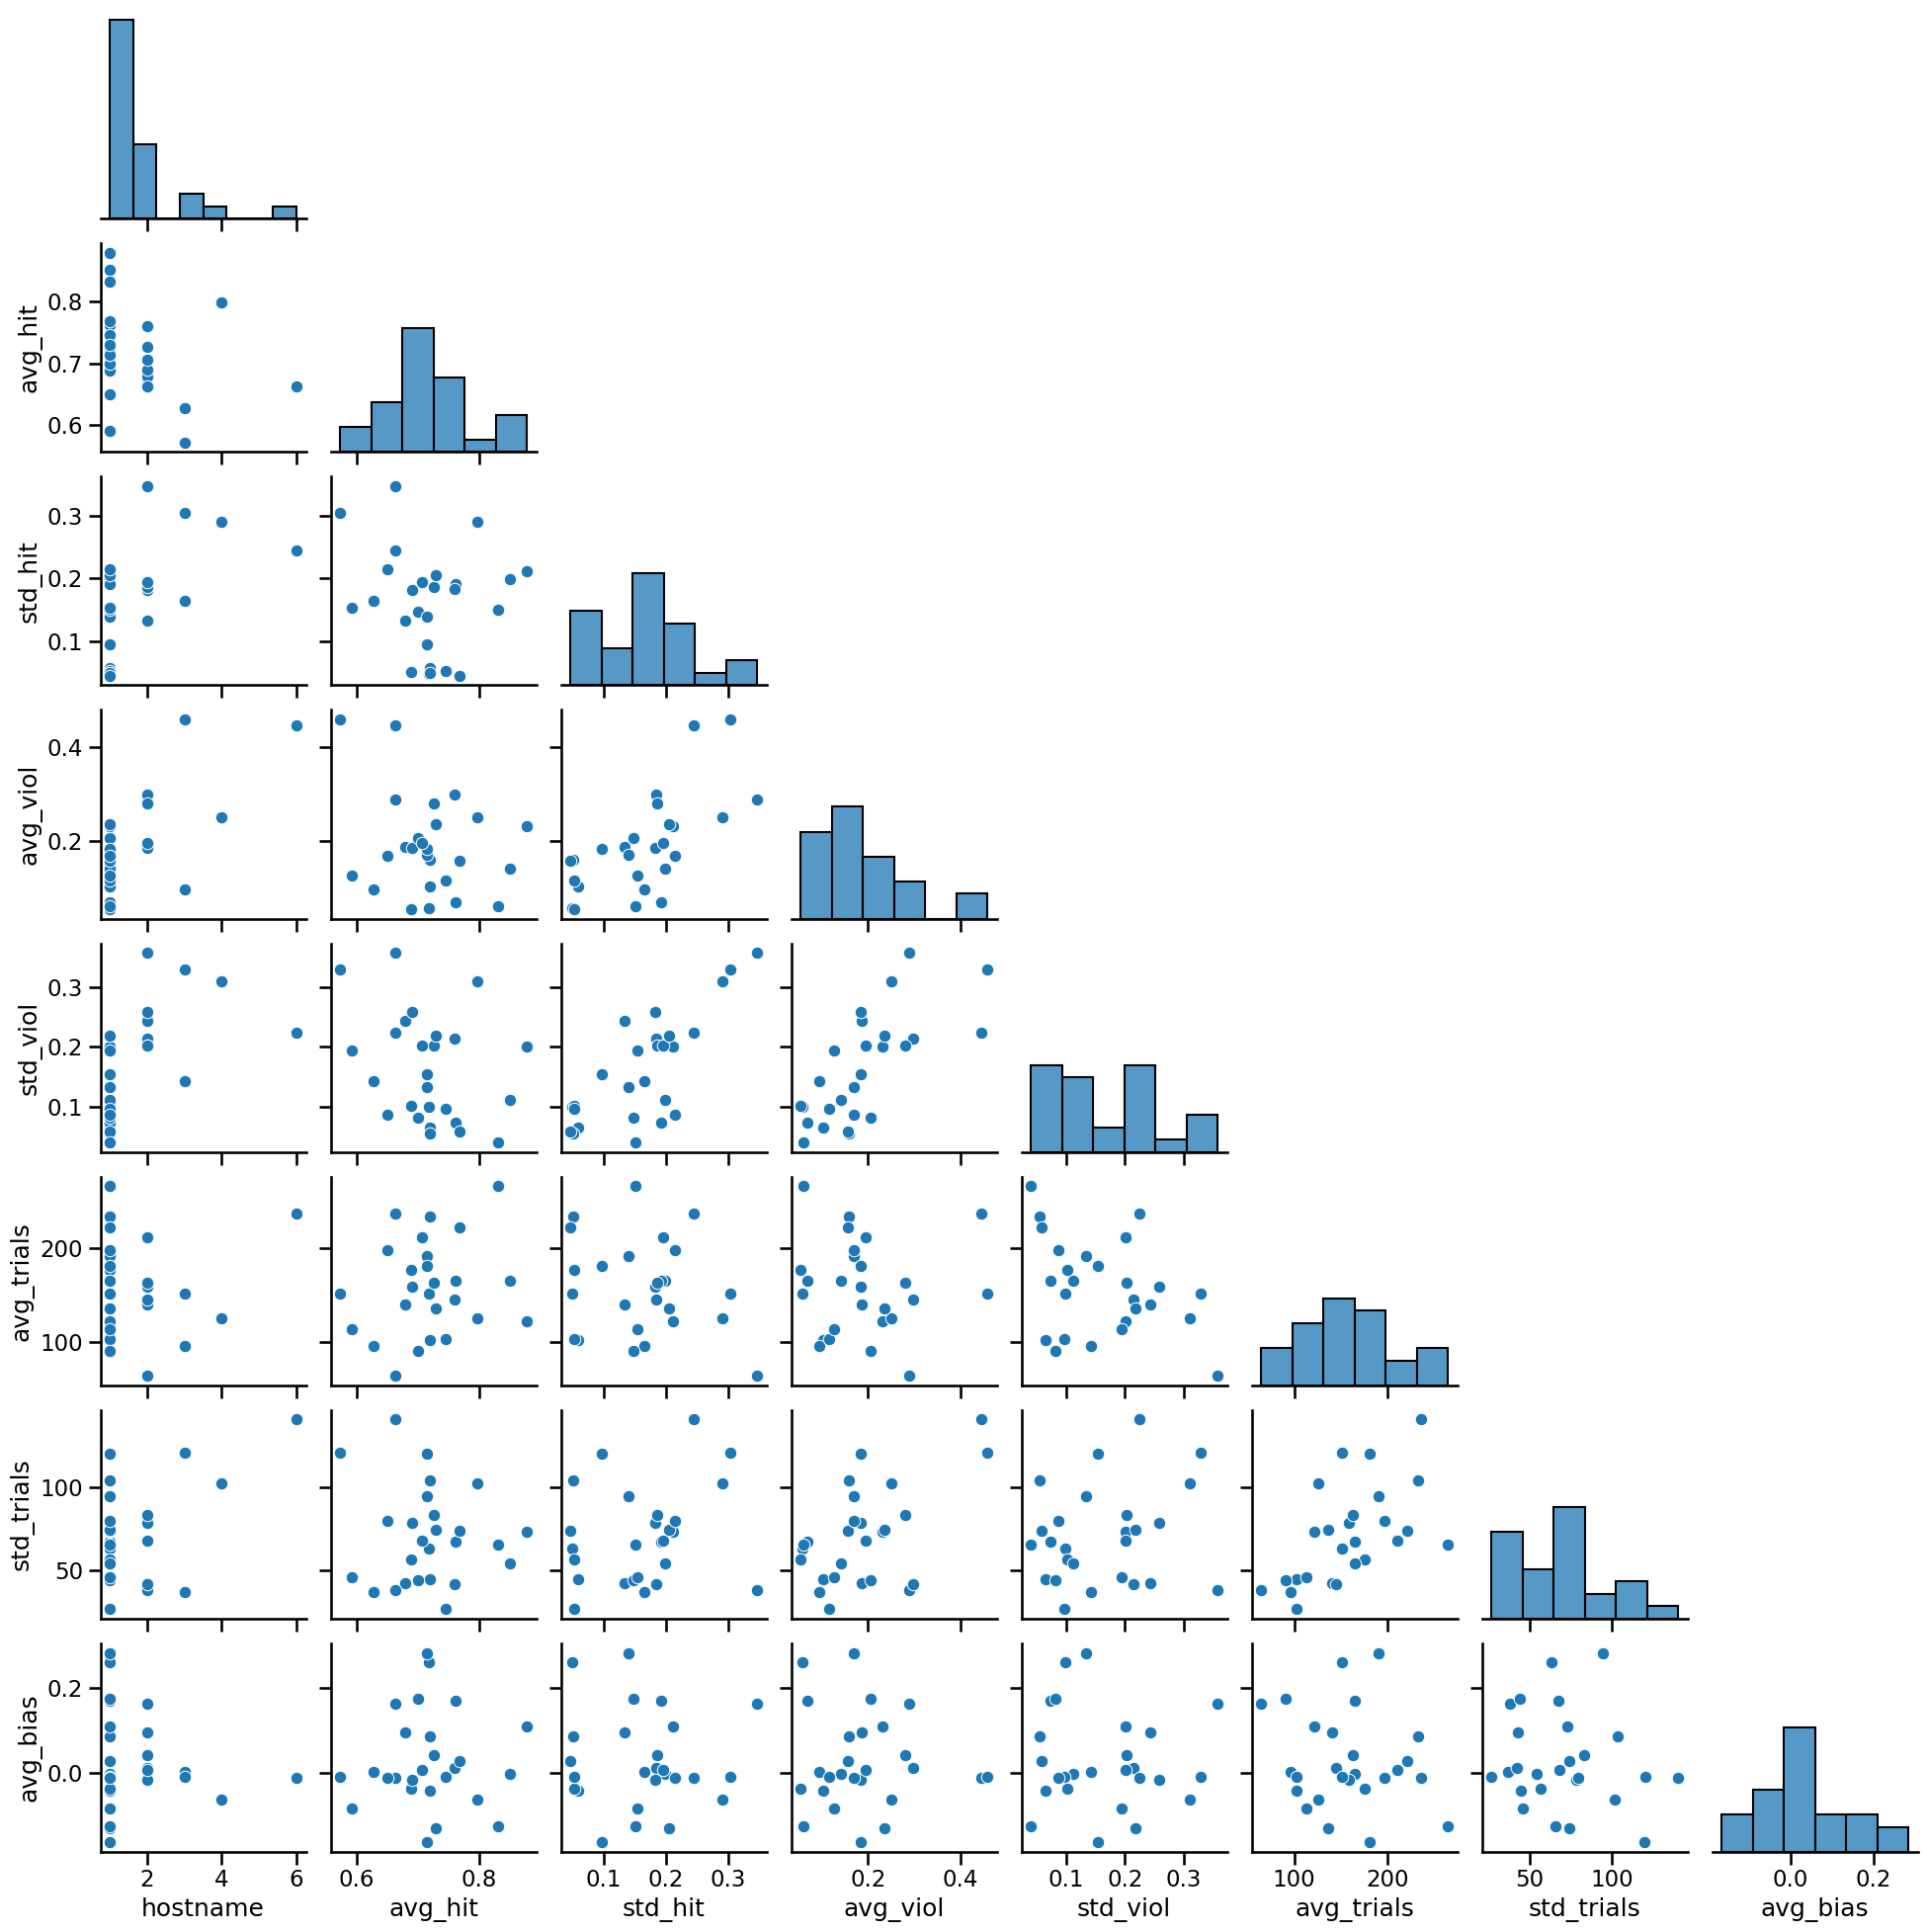

In [175]:
sns.pairplot(rig_data, corner=True)

Next steps:
* make a plot of performance 3 days before rig swtich and 3 days after for hit and viol rates
